# Часть 1. k-Nearest Neighbor (kNN) классификатор

kNN классификатор:
- Во время обучения получает данные и просто запоминает их
- Во время тестирования каждое тестовое изображение сравнивается с каждым обучающим. Итоговая метка получается на основе анализа меток k ближайших обучающих изображений
- Значение k подбирается с помощью кросс-валидации.

Первое упражнение разминочное. Направлено на поминимание pipeline классификации изображений, кросс-валидации и получения практики написания эффективного векторизованного кода, осознания его эффективности.

In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


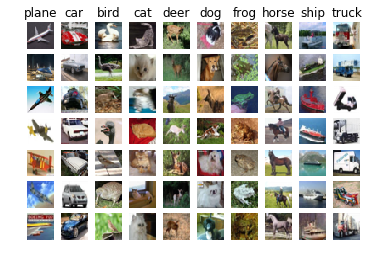

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Нам хочется классифицировать данные с помощью kNN. Вспомним, что этот процесс можно разбить на 2 шага:

1. Посчитать расстояние между каждым обучающим и каждым тестовым примером.
2. Имея эти расстояния для каждого тестового примера найти k ближайших примеров и дать им проголосовать за итоговую метку.

Начать стоит с подсчета матрицы расстояний между всеми обучающими и всеми тестовыми примерами. Например, если у вас **Ntr** обучающих примеров и **Nte** тестовых примеров, то на этом этапе у вас должна получиться матрица из **Nte x Ntr** элементов, где элемент (i, j) равен расстоянию от i-ого обучающего до j-ого тестового примера.

Откройте файл `cs231n/classifiers/k_nearest_neighbor.py` и реализуйте в нём функцию `compute_distances_two_loops`, используя (крайне неэффективный) вложенный цикл по всем парам из (test, train), подсчитывая по одному элементу матрицы за одну итерацию.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


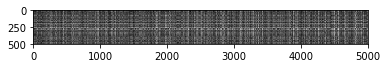

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос №1** Обратите внимание на структурные элементы в матрице расстояний. Какие-то строки и столбцы являются более яркими. (При этом в цветовой схеме по умолчанию чёрный свет соответсвует малым расстояниям, а белый - большим.)

- Что именно в данных приводит к тому, что некоторые строчки отчётливо яркие?
- А столбцы?

**Ваш ответ**: Разница между столбцами и строками заключается в том, что одни отвечают за обучающую выборку, а другие - за тестовую. Поэтому приведу рассуждения для строк.

"Белая строка" означает, что данный объект находится далеко от всех объектов тестовой выборки. Так как объекты - это вектора, представляющие исходные изображения, логично предположить, что это происходит из-за того, что некоторые объекты отличаются по признакам, связанным исключительно со значениями компонент векторов (т.е. с интенсивностью цвета). Простой пример - самолет часто легко отличить от лягушки, потому что самолет - это белые и синие цвета, а лягушка - зеленые и коричневые. Как мне кажется, проблема происходит из-за того, что когда мы сэмплировали выборку, мы не делали никакого решафла, а в исходных данных были какие-то неочевидные зависимости между номерами изображений.

Далее нужно реализовать функцию `
predict_labels`, и запустить следующий код. Получим accuracy для `k = 1`

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Должно получится где-то `27%` accuracy. Теперь попробуем большее значение `k`, например `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


Должно стать немного лучше, чем с `k = 1`.

**Вопрос №2**

Можно также попробовать другую метрику расстояний, например L1.
Качество классификатора по ближайшему соседу с L1 расстоянием не изменится, если (Выберите все подходящие варианты):
1. Данные предобработаны вычитанием среднего.
2. Данные предобработаны вычитанием среднего и делением на дисперсию.
3. Координатные оси данных повёрнуты.
4. Ни одно из вышеперечисленного.

**Ваш ответ**: Верными являются утверждения #1 и #2.

_Подробнее по каждому пункту:_
1. $||x - y|| = ||(x - mean) - (y - mean)||$  
Таким образом, при поиске соседей в матрице расстояний получим те же самые значения. Тогда качество не изменится, так как ответы будут теми же самыми.
2. $\cfrac{||x - y||}{variance} = \left|\left|\cfrac{x - mean}{variance} - \cfrac{y - mean}{variance}\right|\right|$  
В данном случае матрица расстояний будет уменьшена в `variance` раз. Но это не повлияет на поиск ближайших соседей - качество останется прежним.
3. `L1`-метрика не является симметричной
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Vector_norms.svg/140px-Vector_norms.svg.png)
При повороте осей матрица расстояний изменится, и ответы классификатора (т.е. качество) могут измениться.

Теперь нужно немного ускорить подсчёт матрицы расстояний, ограничив число циклов до одного. Реализуйте функцию `compute_distances_one_loop` и запустите код ниже

In [11]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Наконец реализуем полностью векторизованную версию: `compute_distances_no_loops`

In [12]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Осталось сравнить эффективность всех 3 написанных версий

In [13]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 30.070831 seconds
One loop version took 27.681288 seconds
No loop version took 0.248711 seconds


### Cross-validation

Мы построили классификатор, используя k = 5 по умолчанию. Теперь подберём оптимальное значение гиперпараметра с использованием кросс-валидации методом k-fold. Требуется разбить ваши данные на группы (folds) и для каждой группы посчитать accuracy, когда она выделяется как тестовая.

In [14]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

for k in k_choices:
    accuracies = []
    for val_fold in range(num_folds):
        classifier.train(np.delete(X_train_folds, val_fold, 0).reshape(-1, X_train_folds[0].shape[1]),
                         np.delete(y_train_folds, val_fold, 0).reshape(-1,))
        y_val_pred = classifier.predict(X_train_folds[val_fold], k=k)
        num_correct = np.sum(y_val_pred == y_train_folds[val_fold])
        accuracies.append(float(num_correct) / num_test)
    k_to_accuracies[k] = accuracies

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accuracy = 0.556000
k = 1, accuracy = 0.532000
k = 3, accuracy = 0.478000
k = 3, accuracy = 0.498000
k = 3, accuracy = 0.480000
k = 3, accuracy = 0.532000
k = 3, accuracy = 0.508000
k = 5, accuracy = 0.496000
k = 5, accuracy = 0.532000
k = 5, accuracy = 0.560000
k = 5, accuracy = 0.584000
k = 5, accuracy = 0.560000
k = 8, accuracy = 0.524000
k = 8, accuracy = 0.564000
k = 8, accuracy = 0.546000
k = 8, accuracy = 0.580000
k = 8, accuracy = 0.546000
k = 10, accuracy = 0.530000
k = 10, accuracy = 0.592000
k = 10, accuracy = 0.552000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.560000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.590000
k = 12, accuracy = 0.558000
k = 12, accuracy = 0.566000
k = 12, accuracy = 0.560000
k = 15, accuracy = 0.504000
k = 15, accuracy = 0.578000
k = 15, accuracy = 0.556000
k = 15, accuracy = 0.564000
k = 15, accuracy = 0.548000
k = 20, accuracy = 0.540000
k = 20, accu

Построим график зависимости качества от k

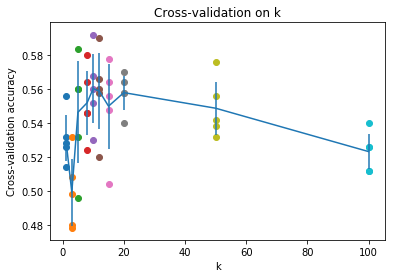

In [15]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

Наконец, выберите лучшее значение k и переобучите классификатор с использованием всех данных для обучения.

In [16]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Вопрос №3**
Какие утверждения про классификатор $k$-Nearest Neighbor ($k$-NN) верны, и для всех ли значений $k$?
1. Качество на обучающих данных будет для 1-NN всегда выше, чем для 5-NN.
2. Качество на тестовых данных будет для 1-NN всегда выше, чем для 5-NN.
3. Разделяющие поверхности k-NN классификатора линейные.
4. Время нужное для классификации тестового примера k-NN классификатором растёт с ростом размера обучающей выборки.
5. Ничего из вышеперечисленного.

**Ваш ответ**: Верными являются утверждения #1 и #4.

_Подробнее по каждому пункту_:
1. В случае `1-NN` во время `predict` будет рассматриваться только одна метка из обучающей выборки. Если подать на вход элемент из обучающей выборки, то ближайшей для него точкой из обучающей выборки будет сама эта точка. Как следствие - отсутствие ошибок при классификации обучающей выборки. В случае `5-NN` во время `predict` будут рассматриваться уже 5 меток - это может сместить классификацию; точность может уменьшиться.
2. Рассмотрим следующий случай: пусть в обучающей выборке один объект первого типа, и 100 объектов второго типа, а в тестовой - 10 объектов второго типа, причем ближайшей для них точкой из обучающей выборки является объект первого типа. Тогда `1-NN` будет постоянно ошибаться, а `5-NN` - правильно классифицировать.
![](https://sketch.io/render/sk-050f5242b54ceaefa682d3ed504b8e39.jpeg)
3. Для начала посмотрим на такой случай: пусть у нас в обучающей выборке всего два объекта, причем эти объекты имеют разные метки. Тогда классификатор поделит всю плоскость на две части следующим образом: проведет серединную гиперплоскость, точки со стороны первого объекта будут получать его метку, а с другой стороны - метку второго объекта. В этом примере получим, что разделяющая гиперплоскость будет линейной.  
Если посмотреть на [этот пример](https://archive.ics.uci.edu/ml/datasets/iris), то видим, что разделяющие поверхности здесь не являются линейными (хотя части поверхностей, несомненно, являются прямыми линиями)
![](http://lijiancheng0614.github.io/scikit-learn/_images/plot_classification_001.png)
Говорим про гиперплоскости, т.к. признаков у объектов может быть неограниченное количество.
4. Во время `predict` рассчитывается расстояние от тестового примера до всех объектов обучающей выборки. Время прямо пропорционально зависит от размера обучающей выборки.

# Часть 2. SVM классификатор

В этом упражнении вы:

- реализуете полностью векторизованную **функцию потерь** для SVM классификатора
- реализуете полностью векторизованное представление его **аналитического градиента**
- **проверите реализацию** числовым градиентом
- используете валидационное множество **чтобы подобрать параметр learning rate и силу регуляризации**
- **оптимизируете** функцию потерь с помощью **SGD**
- **визуализируете** итоговые полученные веса


Загружаем и предобрабатываем данные

In [17]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


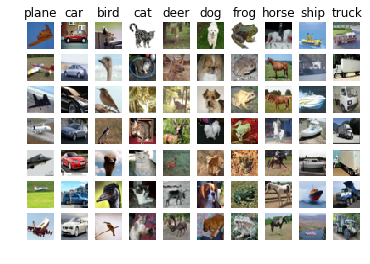

In [18]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [19]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [20]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


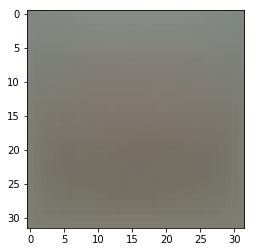

In [21]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [22]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [23]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Весь дальнейший код нужно будет реализовать в файле **cs231n/classifiers/linear_svm.py**. 

Функция `svm_loss_naive` в данном случае уже частично реализована за вас и производит неэффективный подсчёт самого значения loss-а.

In [24]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.068982


Значение `grad`, возаращаемое из функции сейчас состоит из нулей. Реализуйте подсчёт градиента и добавьте его в функцию `svm_loss_naive`.

Для проверки корректности вычисленного градента, можно использовать сравнение с численным градиентом. Код ниже проводит тестирование:

In [25]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 16.289530 analytic: 16.289530, relative error: 2.030656e-11
numerical: 19.209084 analytic: 19.209084, relative error: 1.685604e-11
numerical: 19.375548 analytic: 19.375548, relative error: 2.122776e-11
numerical: 1.764973 analytic: 1.764973, relative error: 7.133026e-11
numerical: 26.980030 analytic: 26.980030, relative error: 1.225935e-12
numerical: -4.737275 analytic: -4.737275, relative error: 1.297012e-10
numerical: -1.420379 analytic: -1.420379, relative error: 2.123416e-10
numerical: 2.222812 analytic: 2.222812, relative error: 1.137687e-10
numerical: -17.610159 analytic: -17.555463, relative error: 1.555386e-03
numerical: -21.828563 analytic: -21.828563, relative error: 3.355281e-12
numerical: -43.299073 analytic: -43.267220, relative error: 3.679589e-04
numerical: 13.433475 analytic: 13.433475, relative error: 4.650722e-12
numerical: 12.085845 analytic: 12.037438, relative error: 2.006641e-03
numerical: 15.809217 analytic: 15.809217, relative error: 3.886043e-13
nume

**Вопрос №1**
Иногда бывает так, что в какой-то момент одно из измерений при сравнении градиентов не будет подностью совпадать. Что может приводить к подобному разбросу? Стоит ли по этому поводу волноваться? Можно ли привести простой пример, в котором сравнение градиентов в одном из измерений сработает неправильно? Как можно повлиять на частоту возникновения подобных граничных эффектов? *Подсказка: SVM loss строго говоря не дифференцируется*

**Ваш ответ:**
Ошибки могут быть связаны с погрешностью вычислений. Для вычисления производной используется следующая приближенная формула
$$f'(x) = \cfrac{f(x+h) - f(x-h)}{2h}$$
Погрешность этой формулы имеет второй порядок по `h`. Тогда, при $h = 10^{-5}$ погрешность численной производной будет $10^{-10}$. При расчетах с использованием `double` точность измеряется в пределах $2^{-64} \approx 10^{-19}$. Видим, что при вычислении градиента с использованием точной формулы погрешность значительно меньше.

Эта проблема не является существенной - при изменении параметров моделей с помощью градиентного спуска мы все равно будем смещаться в нужную сторону.

Простой пример, когда возникает проблема: возьмем какую-нибудь недифференцируемую в нуле функцию
$$x \cdot I\{x > 0\}$$
В случае с точной формулой мы вообще мало что можем сделать (логично, наверное, доопределить каким-то значением). При вычислении по численной формуле получим
$$f'(x)_{x=x_{0}} = 0.5$$

Стандартный прием борьбы с такими проблемами - использование штрафных и барьерных функций.

Далее нужно реализовать векторизованную версию кода: `svm_loss_vectorized`.

In [26]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.068982e+00 computed in 0.120869s
Vectorized loss: 9.068982e+00 computed in 0.016371s
difference: -0.000000


In [27]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.127521s
Vectorized loss and gradient: computed in 0.005606s
difference: 0.000000


### Stochastic Gradient Descent

Теперь мы умеем эффективно считать выражения для loss-а и его градиента, причём градиент совпадает с численным. Теперь мы готовы к оптимизации loss-а.

Реализуйте функцию `LinearClassifier.train()` в файле `linear_classifier.py`

In [28]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 775.912711
iteration 100 / 1500: loss 284.835462
iteration 200 / 1500: loss 107.309465
iteration 300 / 1500: loss 42.152784
iteration 400 / 1500: loss 18.673201
iteration 500 / 1500: loss 10.054205
iteration 600 / 1500: loss 6.803731
iteration 700 / 1500: loss 6.024163
iteration 800 / 1500: loss 5.804819
iteration 900 / 1500: loss 5.113340
iteration 1000 / 1500: loss 5.440761
iteration 1100 / 1500: loss 5.955665
iteration 1200 / 1500: loss 5.577010
iteration 1300 / 1500: loss 5.849262
iteration 1400 / 1500: loss 5.161636
That took 13.950493s


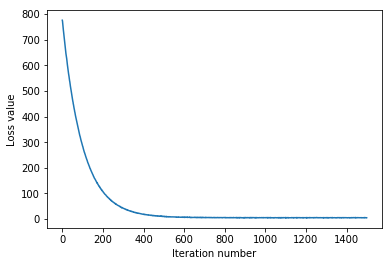

In [29]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

А теперь потребуется реализацию функции `LinearClassifier.predict()`

In [30]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369673
validation accuracy: 0.374000


Подберите значения гиперпараметров: силы регуляризации и скорости обучения

In [31]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = np.arange(1.6e-7, 1.8e-7, 0.3e-8)
regularization_strengths = np.arange(4e3, 6e3, 3e2)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
    for reg in regularization_strengths:
        clf = LinearSVM()
        clf.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        
        y_train_pred = clf.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = clf.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = clf
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.600000e-07 reg 4.000000e+03 train accuracy: 0.366776 val accuracy: 0.364000
lr 1.600000e-07 reg 4.300000e+03 train accuracy: 0.371143 val accuracy: 0.363000
lr 1.600000e-07 reg 4.600000e+03 train accuracy: 0.373041 val accuracy: 0.377000
lr 1.600000e-07 reg 4.900000e+03 train accuracy: 0.364204 val accuracy: 0.371000
lr 1.600000e-07 reg 5.200000e+03 train accuracy: 0.373571 val accuracy: 0.365000
lr 1.600000e-07 reg 5.500000e+03 train accuracy: 0.376449 val accuracy: 0.372000
lr 1.600000e-07 reg 5.800000e+03 train accuracy: 0.380510 val accuracy: 0.404000
lr 1.630000e-07 reg 4.000000e+03 train accuracy: 0.370694 val accuracy: 0.367000
lr 1.630000e-07 reg 4.300000e+03 train accuracy: 0.370429 val accuracy: 0.351000
lr 1.630000e-07 reg 4.600000e+03 train accuracy: 0.367939 val accuracy: 0.372000
lr 1.630000e-07 reg 4.900000e+03 train accuracy: 0.373857 val accuracy: 0.378000
lr 1.630000e-07 reg 5.200000e+03 train accuracy: 0.377204 val accuracy: 0.377000
lr 1.630000e-07 reg 5.500000

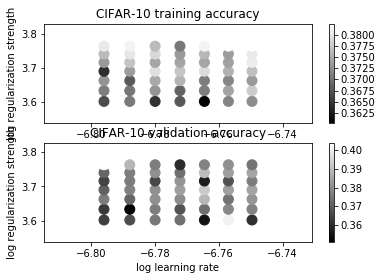

In [32]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [33]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


Осталось визуализировать обученные веса для всех классов

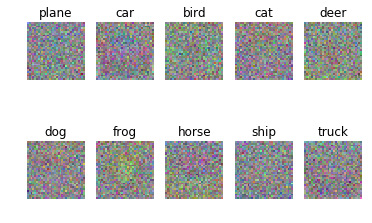

In [34]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# Часть 3. Softmax классификатор

В этом упражнении вы:

- реализуете полностью векторизованную **функцию потерь** для Softmax классификатора
- реализуете полностью векторизованное представление его **аналитического градиента**
- **проверите реализацию** числовым градиентом
- используете валидационное множество **чтобы подобрать параметр learning rate и силу регуляризации**
- **оптимизируете** функцию потерь с помощью **SGD**
- **визуализируете** итоговые полученные веса

Примечание: требуется код, написанный в части 2.

In [35]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Код в этой секции нужно писать в файле **cs231n/classifiers/softmax.py**. 
Для начала реализуйте функцию `softmax_loss_naive`

In [36]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372887
sanity check: 2.302585


**Вопрос №1**
Почему мы ожидаем значение функции потерь -log(0.1)? Дайте краткий ответ.

**Ваш ответ**: В начале все классы имеют почти одинаковый `score` (близкий к 0), поэтому значения `softmax` будут похожими. Так как классов 10, то получим
$$Loss \approx -log\left(\cfrac{e^{0}}{\sum_{1}^{10}e^{0}}\right) \approx -log(0.1)$$

Допишите вашу реализацию, чтобы она также возвращала и корректный градиент. Ячейка ниже проверит его на корректность по сравнению с числовым градиентом.

In [37]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -6.753812 analytic: -6.753813, relative error: 9.017098e-10
numerical: -1.038043 analytic: -1.038043, relative error: 6.496176e-08
numerical: 0.336065 analytic: 0.336065, relative error: 7.895096e-08
numerical: 2.549307 analytic: 2.549307, relative error: 2.144710e-08
numerical: 0.659773 analytic: 0.659772, relative error: 8.497040e-08
numerical: -1.056757 analytic: -1.056757, relative error: 9.399436e-08
numerical: 0.367526 analytic: 0.367526, relative error: 1.354265e-07
numerical: -2.499379 analytic: -2.499379, relative error: 1.530929e-08
numerical: 3.552621 analytic: 3.552621, relative error: 3.283463e-10
numerical: 0.207585 analytic: 0.207585, relative error: 1.505460e-08
numerical: 1.361501 analytic: 1.361501, relative error: 1.317494e-08
numerical: -2.532388 analytic: -2.532388, relative error: 1.254853e-08
numerical: -0.824894 analytic: -0.824894, relative error: 7.747554e-08
numerical: -2.178519 analytic: -2.178519, relative error: 3.531246e-08
numerical: -0.627476

Теперь реализуйте функцию `softmax_loss_vectorized` - подсчёт того же самого значения и градиента с использованием векторных операций.

In [38]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372887e+00 computed in 0.103603s
vectorized loss: 2.372887e+00 computed in 0.010390s
Loss difference: 0.000000
Gradient difference: 0.000000


Используйте валидационное множество для подбора гиперпараметров силы регуляризации и скорости обучения.

In [39]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.arange(1.6e-7, 1.8e-7, 0.3e-8)
regularization_strengths = np.arange(4e3, 6e3, 3e2)

for lr in learning_rates:
    for reg in regularization_strengths:
        clf = Softmax()
        clf.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        
        y_train_pred = clf.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = clf.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = clf
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.600000e-07 reg 4.000000e+03 train accuracy: 0.323857 val accuracy: 0.335000
lr 1.600000e-07 reg 4.300000e+03 train accuracy: 0.329571 val accuracy: 0.339000
lr 1.600000e-07 reg 4.600000e+03 train accuracy: 0.331184 val accuracy: 0.349000
lr 1.600000e-07 reg 4.900000e+03 train accuracy: 0.336388 val accuracy: 0.345000
lr 1.600000e-07 reg 5.200000e+03 train accuracy: 0.339796 val accuracy: 0.354000
lr 1.600000e-07 reg 5.500000e+03 train accuracy: 0.343224 val accuracy: 0.329000
lr 1.600000e-07 reg 5.800000e+03 train accuracy: 0.341714 val accuracy: 0.367000
lr 1.630000e-07 reg 4.000000e+03 train accuracy: 0.325265 val accuracy: 0.319000
lr 1.630000e-07 reg 4.300000e+03 train accuracy: 0.336245 val accuracy: 0.327000
lr 1.630000e-07 reg 4.600000e+03 train accuracy: 0.338633 val accuracy: 0.322000
lr 1.630000e-07 reg 4.900000e+03 train accuracy: 0.341286 val accuracy: 0.342000
lr 1.630000e-07 reg 5.200000e+03 train accuracy: 0.342449 val accuracy: 0.340000
lr 1.630000e-07 reg 5.500000

Наконец посчитайте значение accuracy для лучшего классификатора.

In [40]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**Вопрос №2**
Возможно ли, что при добавлении нового примера в обучающих данных SVM loss бы не изменился, но Softmax loss при этом бы поменялся?

**Ваш ответ**: Возможно.

_Подробнее_: Допустим, что мы решаем задачу трехклассовой классификации, и что в выборке сейчас два примера:

| Scores  | Object 1 | Object 2 |
|---------|----------|----------|
| Class 1 | **3.2**  | 2.2      |
| Class 2 | 5.1      | 2.5      |
| Class 3 | -1.7     | **-3.1** |

| Object Loss  | Object 1 | Object 2 |
|--------------|----------|----------|
| SVM Loss     | 2.9      | 12.9     |
| Softmax Loss | 2.04     | 6.16     |

| Total Loss | SVM     | Softmax |
|------------|---------|---------|
| Value      | 7.9     | 4.1     |

Добавим еще один объект в выборку:

| Scores  | Object 1 | Object 2 | Object 3 |
|---------|----------|----------|----------|
| Class 1 | **3.2**  | 2.2      | 7.0      |
| Class 2 | 5.1      | 2.5      | **1.0**  |
| Class 3 | -1.7     | **-3.1** | 0.9      |

| Object Loss  | Object 1 | Object 2 | Object 3 |
|--------------|----------|----------|----------|
| SVM Loss     | 2.9      | 12.9     | 7.9      |
| Softmax Loss | 2.04     | 6.16     | 6.0      |

| Total Loss | SVM     | Softmax |
|------------|---------|---------|
| Value      | 7.9     | 4.73    |

Как видим, `SVM TotalLoss` остался прежним, а `Softmax TotalLoss` изменился.

Осталось визуализировать обученные веса для всех классов

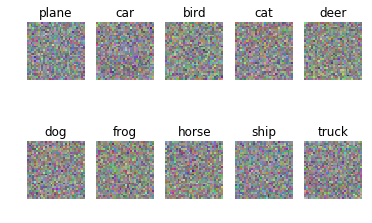

In [41]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])